![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 07 - PyTorch</center>
### <center> Schdeulers</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/07_PyTorch/MainPyTorchSchdulers.ipynb)

In [3]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#-- Imports:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

### Record figures during training:

In [6]:
class Plot:
    def __init__(self, sTitle, sLabel, sXlabel, sColor, vData=[]):
        self.sTitle  = sTitle
        self.sLabel  = sLabel
        self.sXlabel = sXlabel
        self.sColor  = sColor
        self.vData   = vData

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Recorder:
    def __init__(self, lPlots, figsize=(12,4)):
        self.lTitles = np.unique([oPlot.sTitle for oPlot in lPlots])
        self.N       = len(self.lTitles)
        self.fig, _  = plt.subplots(1, self.N, figsize=(12, 4))
        self.dAxes   = {}
        ii           = 0
        for oPlot in lPlots:
            ax = self.dAxes.get(oPlot.sTitle, None)
            if ax == None:
                ax                       = self.fig.axes[ii]
                ii                      += 1
                self.dAxes[oPlot.sTitle] = ax

            ax.set_title(oPlot.sTitle)
            ax.set_xlabel(oPlot.sXlabel)
            ax.plot(oPlot.vData, c=oPlot.sColor, label=oPlot.sLabel)
            ax.legend()
            ax.grid(True)

        plt.tight_layout()

    def Append(self, sTitle, sLabel, vData):
        ax = self.dAxes[sTitle]
        for oLine in ax.lines:
            if oLine.get_label() == sLabel:
                vYdata = np.append(oLine.get_ydata(), vData)
                N      = len(vYdata)
                oLine.set_data(list(range(N)), vYdata)
        lYlim = ax.axis()[2:4]
        if N > 1:
            ax.axis(xmin=0, xmax=N, ymin=np.minimum(np.min(vData), lYlim[0]), ymax=np.maximum(np.max(vData), lYlim[1]))
        else:
            ax.axis(xmin=0, xmax=N, ymin=np.min(vData), ymax=np.max(vData)+1e-10)

    def Draw(self):
        self.fig.canvas.draw()
        plt.pause(1e-10)

### Training loop:

In [7]:
def Accuracy(mHatY, vY):
    vHatY = mHatY.argmax(dim=1)
    return (vHatY == vY).float().mean().item()

In [8]:
import time

def TrainLoop(oModel, oTrainDL, LossFunc, oOptim, oScheduler):

    epochLoss = 0
    epochAcc  = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    oModel.train(True)
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(device)
        vY = vY.to(device)
        
        #-- Set gradients to zeros:
        oOptim.zero_grad()
        
        #-- Forward:
        mHatY = oModel(mX)
        loss  = LossFunc(mHatY, vY)

        #-- Backward:
        loss.backward()

        #-- Parameters update:
        oOptim.step()
        if oScheduler is not None and isinstance(oScheduler, optim.lr_scheduler.CyclicLR):
            oScheduler.step()

        print(f'Iteration: {ii:3d}: loss = {loss:.6f}\r', end='')
        #-- Accumulate loss:
        Nb         = mX.shape[0]
        epochLoss += Nb * loss.item()
        epochAcc  += Nb * Accuracy(mHatY, vY)
        count     += Nb

    epochLoss /= count
    epochAcc  /= count

    if oScheduler is not None and not isinstance(oScheduler, optim.lr_scheduler.CyclicLR):
        oScheduler.step()
    
    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationLoop(oModel, oValDL, LossFunc):

    if oValDL is None:
        return 0, 0
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    
    #-- Iterate over the mini-batches:
    oModel.train(False)
    with torch.no_grad():
        for ii, (mX, vY) in enumerate(oValDL):
            #-- Move to device (CPU\GPU):
            mX = mX.to(device)
            vY = vY.to(device)
            
            #-- Forward:
            mHatY = oModel(mX)
            loss  = LossFunc(mHatY, vY)

            Nb         = len(vY)
            epochLoss += Nb * loss.item()
            epochAcc  += Nb * Accuracy(mHatY, vY)
            count     += Nb

    epochLoss /= count
    epochAcc  /= count

    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def TrainModel(oModel, oTrainDL, oValDL, LossFunc, numEpochs, oOptim, oScheduler=None):

    oRecorder = Recorder([
        Plot('Loss',          'train', 'epoch', 'b'),
        Plot('Loss',          'val',   'epoch', 'r'),
        Plot('Accuracy',      'train', 'epoch', 'b'),
        Plot('Accuracy',      'val',   'epoch', 'r'),
        Plot('Learning rate', 'lr',    'epoch', 'b'),
    ])

    oRecorder.Append('Learning rate', 'lr', oOptim.param_groups[0]['lr']),
    
    bestAcc = 0
    for epoch in range(numEpochs):
        
        startTime           = time.time()
        trainLoss, trainAcc = TrainLoop(oModel, oTrainDL, LossFunc, oOptim, oScheduler) #-- train
        valLoss,   valAcc   = ValidationLoop(oModel, oValDL, LossFunc)                  #-- validation
        
        #-- Display:
        oRecorder.Append('Loss',          'train', trainLoss),
        oRecorder.Append('Loss',          'val',   valLoss),
        oRecorder.Append('Accuracy',      'train', trainAcc),
        oRecorder.Append('Accuracy',      'val',   valAcc),
        oRecorder.Append('Learning rate', 'lr',    oOptim.param_groups[0]['lr']),
        oRecorder.Draw()

        endTime = time.time()
        print('Epoch '              f'{epoch:3d}:',                  end='')
        print(' | Train loss: '     f'{trainLoss:.5f}',              end='')
        print(' | Val loss: '       f'{valLoss:.5f}',                end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}',              end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',                end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |', end='')
        
        #-- Save best model:
        if valAcc > bestAcc:
            bestAcc   = valAcc
            try:
                torch.save(oModel.state_dict(), 'BestModelParameters.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print()

    oModel.load_state_dict(torch.load('BestModelParameters.pt'))

In [9]:
def LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate):
   
    #-- Record mini-batches loss:
    oRecorder = Recorder([Plot('Batch loss', 'train', 'learning rate', 'b')])

    numIter = len(vLearningRate)
    ii      = 0
    while ii < numIter:
        #-- Iterate over the mini-batches:
        for mX, vY in oTrainDL:
            if ii >= numIter:
                break

            #-- Move to device (CPU\GPU):
            mX = mX.to(device)
            vY = vY.to(device)
                        
            #-- Set gradients to zeros:
            oOptim.zero_grad()
                
            #-- Forward:
            mHatY = oModel(mX)
            loss  = LossFunc(mHatY, vY)

            #-- Backward:
            loss.backward()

            #-- Update parameters (with new learning rate)
            oOptim.param_groups[0]['lr'] = vLearningRate[ii]
            oOptim.step()

            oRecorder.Append('Batch loss', 'train', loss.item())
            oRecorder.Draw()        
        
            ii += 1
            
    #-- Display:
    ax = oRecorder.dAxes['Batch loss']
    ax.lines[0].set_xdata(vLearningRate)
    ax.axis(xmin=vLearningRate[0], xmax=vLearningRate[-1])
    ax.set_xscale('log')
    oRecorder.Draw()

### Download MNIST dataset:

In [10]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transforms.ToTensor())
oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

### Compute mean and variance:

In [42]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std((0,1,2))  / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


### Set datasets with normalization:

In [12]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet = torchvision.datasets.CIFAR10(root='../data', train=True,  transform=oTransform)
oTestSet  = torchvision.datasets.CIFAR10(root='../data', train=False, transform=oTransform)

lClasses  = oTrainSet.classes
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Plot some examples:

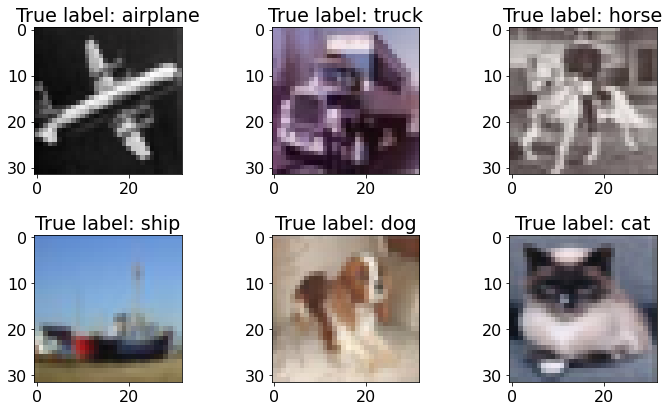

In [13]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    mX    = mX * vStd[:,None,None] + vMean[:,None,None] #-- unnormalizing
    mX    = torch.clamp(mX, 0, 1)
    ax.imshow(np.transpose(mX.numpy(), (1,2,0)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

### Create data loaders:

In [46]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize)

### Define the model (2D CNN):

In [66]:
import torch.nn            as nn
import torch.nn.functional as F
import torchsummary


class GReLU(nn.Module):
    def __init__(self, leak=0.01, sub=0.4, maxVal=6.):
        super(GReLU, self).__init__()
        self.leak   = leak
        self.sub    = sub
        self.maxVal = maxVal
    
    def forward(self, mX):
        mZ = F.leaky_relu(mX, self.leak).clamp(max=self.maxVal) - self.sub
        return mZ


#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def WeightInit(oModule):
    if isinstance(oModule, nn.Conv2d):
        nn.init.kaiming_normal_(oModule.weight.data)

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Tensor to vector (reshape):
class Flatten(nn.Module):
    def forward(self, mX):
        N  = mX.shape[0]
        mZ = mX.view(N, -1)
        return mZ

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Just for the summary (identity):
class InputLayer(nn.Module):
    def forward(self, mX):
        return mX
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Model:
def GetModel():
    
    p      = 0.15
    oModel = nn.Sequential(
        InputLayer(), #-- does nothing
        
        nn.Conv2d(3,   30,  3, stride=1, bias=False),                  nn.BatchNorm2d(30),  GReLU(), nn.Dropout2d(p),
        nn.Conv2d(30,  60,  3, stride=1, bias=False), nn.MaxPool2d(2), nn.BatchNorm2d(60),  GReLU(), nn.Dropout2d(p),
        nn.Conv2d(60,  120, 3, stride=1, bias=False),                  nn.BatchNorm2d(120), GReLU(), nn.Dropout2d(p),
        nn.Conv2d(120, 240, 3, stride=1, bias=False), nn.MaxPool2d(2), nn.BatchNorm2d(240), GReLU(), nn.Dropout2d(p),
        nn.Conv2d(240, 500, 3, stride=1, bias=False),                  nn.BatchNorm2d(500), GReLU(), nn.Dropout2d(p),
                
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(500, 200), nn.ReLU(), nn.Dropout2d(p),
        nn.Linear(200, 10)
    )
    
    oModel.apply(WeightInit)
    
    return oModel

#-- Model:
def GetModel2():
    
    p      = 0.1
    oModel = nn.Sequential(
        InputLayer(), #-- does nothing
        
        nn.Conv2d(3,   30,  3, stride=1, bias=False),                  nn.BatchNorm2d(30),  GReLU(), nn.Dropout2d(p),
        nn.Conv2d(30,  100, 3, stride=1, bias=False), nn.MaxPool2d(2), nn.BatchNorm2d(100), GReLU(), nn.Dropout2d(p),
        nn.Conv2d(100, 200, 3, stride=1, bias=False),                  nn.BatchNorm2d(200), GReLU(), nn.Dropout2d(p),
        nn.Conv2d(200, 400, 3, stride=1, bias=False),                  nn.BatchNorm2d(400), GReLU(), nn.Dropout2d(p),
                
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(400, 100), nn.ReLU(), nn.Dropout2d(p),
        nn.Linear(100, 10)
    )
    
    oModel.apply(WeightInit)
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel2(), (3, H, W), device='cpu')
print()

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─InputLayer: 1-1                        [-1, 3, 32, 32]           --
├─Conv2d: 1-2                            [-1, 30, 30, 30]          810
├─BatchNorm2d: 1-3                       [-1, 30, 30, 30]          60
├─GReLU: 1-4                             [-1, 30, 30, 30]          --
├─Dropout2d: 1-5                         [-1, 30, 30, 30]          --
├─Conv2d: 1-6                            [-1, 100, 28, 28]         27,000
├─MaxPool2d: 1-7                         [-1, 100, 14, 14]         --
├─BatchNorm2d: 1-8                       [-1, 100, 14, 14]         200
├─GReLU: 1-9                             [-1, 100, 14, 14]         --
├─Dropout2d: 1-10                        [-1, 100, 14, 14]         --
├─Conv2d: 1-11                           [-1, 200, 12, 12]         180,000
├─BatchNorm2d: 1-12                      [-1, 200, 12

### Check whether GPU is available:

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [20]:
import torch.optim as optim
LossFunc = nn.CrossEntropyLoss()

###  Search learning rate:

In [21]:
import torch.optim as optim
LossFunc      = nn.CrossEntropyLoss()

<IPython.core.display.Javascript object>


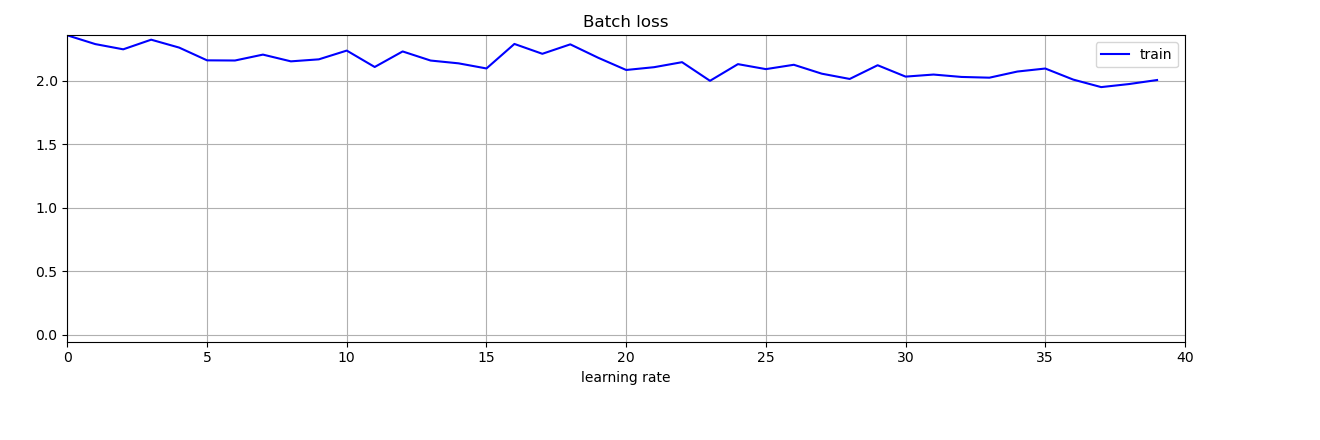

KeyboardInterrupt: 

In [73]:
%matplotlib notebook

oModel        = GetModel().to(device)
oOptim        = optim.AdamW(oModel.parameters(), lr=0.1, betas=(0.9, 0.99), weight_decay=1e-2)
vLearningRate = np.logspace(-3, -1, 301)
LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate)

### Train the model:

<IPython.core.display.Javascript object>


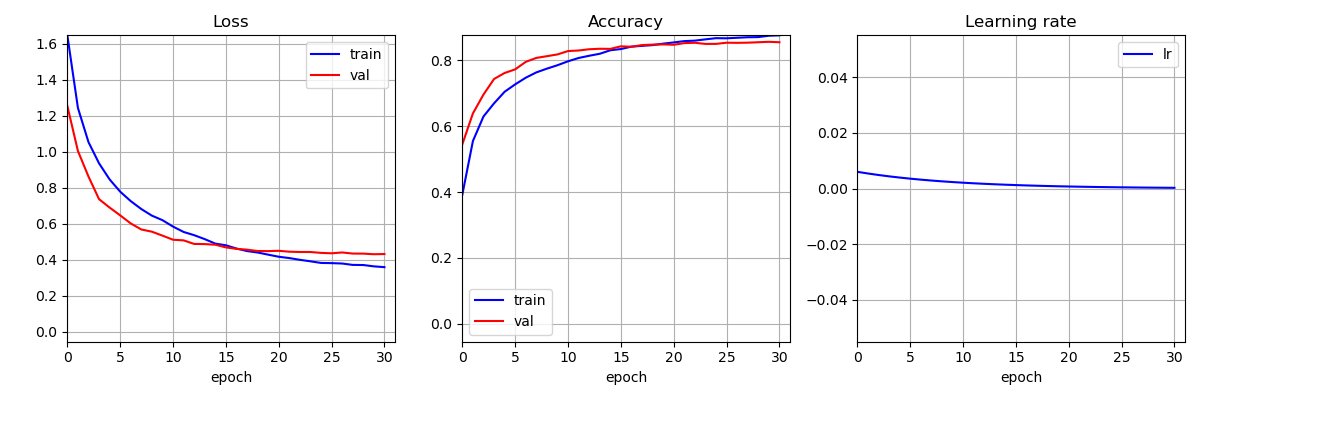

Epoch   0: | Train loss: 1.64752 | Val loss: 1.25498 | Train Accuracy: 0.3923 | Val Accuracy: 0.5452 | epoch time: 28.721 | <-- Checkpoint!
Epoch   1: | Train loss: 1.24421 | Val loss: 1.00500 | Train Accuracy: 0.5550 | Val Accuracy: 0.6389 | epoch time: 28.478 | <-- Checkpoint!
Epoch   2: | Train loss: 1.05419 | Val loss: 0.86281 | Train Accuracy: 0.6296 | Val Accuracy: 0.6963 | epoch time: 27.665 | <-- Checkpoint!
Epoch   3: | Train loss: 0.93621 | Val loss: 0.73701 | Train Accuracy: 0.6695 | Val Accuracy: 0.7435 | epoch time: 28.609 | <-- Checkpoint!
Epoch   4: | Train loss: 0.84679 | Val loss: 0.69043 | Train Accuracy: 0.7047 | Val Accuracy: 0.7618 | epoch time: 28.750 | <-- Checkpoint!
Epoch   5: | Train loss: 0.77876 | Val loss: 0.64707 | Train Accuracy: 0.7272 | Val Accuracy: 0.7728 | epoch time: 30.827 | <-- Checkpoint!
Epoch   6: | Train loss: 0.72619 | Val loss: 0.60226 | Train Accuracy: 0.7474 | Val Accuracy: 0.7956 | epoch time: 29.474 | <-- Checkpoint!
Epoch   7: | Train l

KeyboardInterrupt: 

In [84]:
%matplotlib notebook

oModel = GetModel().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=6e-3, betas=(0.9, 0.99), weight_decay=1e-2)

oScheduler = optim.lr_scheduler.ExponentialLR(oOptim, 0.9)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, 50, oOptim, oScheduler)

<IPython.core.display.Javascript object>


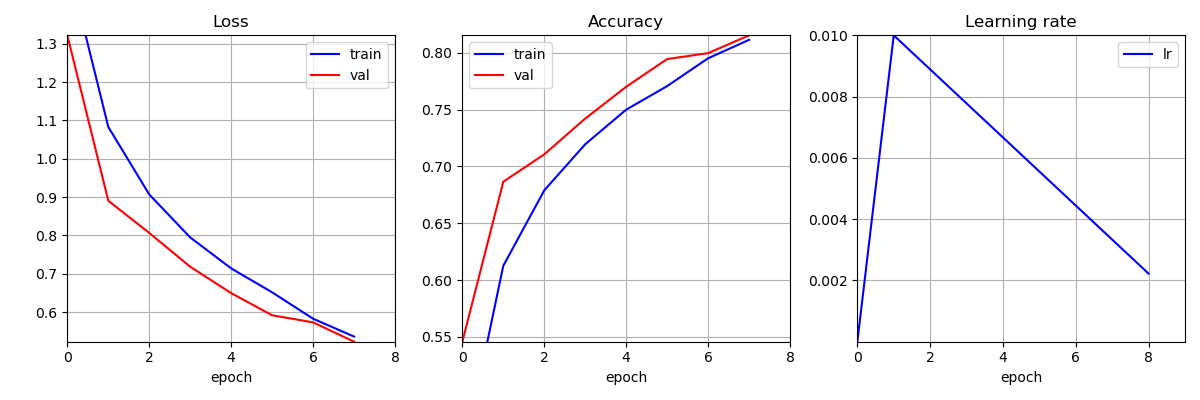

Epoch   0: | Train loss: 1.51466 | Val loss: 1.32180 | Train Accuracy: 0.4408 | Val Accuracy: 0.5457 | epoch time: 32.006 | <-- Checkpoint!
Epoch   1: | Train loss: 1.08274 | Val loss: 0.89027 | Train Accuracy: 0.6126 | Val Accuracy: 0.6866 | epoch time: 30.885 | <-- Checkpoint!
Epoch   2: | Train loss: 0.90665 | Val loss: 0.80634 | Train Accuracy: 0.6790 | Val Accuracy: 0.7107 | epoch time: 31.568 | <-- Checkpoint!
Epoch   3: | Train loss: 0.79457 | Val loss: 0.71810 | Train Accuracy: 0.7196 | Val Accuracy: 0.7422 | epoch time: 29.711 | <-- Checkpoint!
Epoch   4: | Train loss: 0.71383 | Val loss: 0.64934 | Train Accuracy: 0.7500 | Val Accuracy: 0.7702 | epoch time: 29.873 | <-- Checkpoint!
Epoch   5: | Train loss: 0.65141 | Val loss: 0.59148 | Train Accuracy: 0.7708 | Val Accuracy: 0.7946 | epoch time: 29.625 | <-- Checkpoint!
Epoch   6: | Train loss: 0.58256 | Val loss: 0.57306 | Train Accuracy: 0.7953 | Val Accuracy: 0.7998 | epoch time: 30.557 | <-- Checkpoint!
Epoch   7: | Train l

In [ ]:
%matplotlib notebook

oModel = GetModel2().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=0, betas=(0.8, 0.9), weight_decay=5e-3)
# oOptim = optim.Adam(oModel.parameters(), lr=0, betas=(0.9, 0.99))

iterPerEpoch = len(oTrainDL)
numStepsUp   = 1 * iterPerEpoch
numStepsDown = 9 * iterPerEpoch

oScheduler = optim.lr_scheduler.CyclicLR(oOptim, 1e-6, 1e-2, numStepsUp, numStepsDown, cycle_momentum=False, mode='triangular2')
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, 30, oOptim, oScheduler)
